# Heart Rate Recovery Analysis

## Theory
Inability to recover heart rate to pre-exercise values may suggest sympathetic and/or
parasympathetic nervous system dysfunction.

## Purpose
Analysis of heart rate following maximal exercise testing.

## Outline
- Load heart rate data
- Clean data via filtering, time normalization, and resampling
- Apply different analytical methods

## Import Statements

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from math import exp, floor, ceil
from scipy.signal import resample
from scipy.stats import linregress

## Functions

In [2]:
def median_absolute_deviation(x):
    """
    Returns the median absolute deviation from the window's median
    :param x: Values in the window
    :return: MAD
    """
    return np.median(np.abs(x - np.median(x)))


In [3]:
def hampel(ts, window_size=5, n=3, imputation=False):
    # source: https://github.com/MichaelisTrofficus/hampel_filter
    # tremendous thanks for making this, and in effect making my life easier

    """
    Median absolute deviation (MAD) outlier in Time Series
    :param ts: a pandas Series object representing the timeseries
    :param window_size: total window size will be computed as 2*window_size + 1
    :param n: threshold, default is 3 (Pearson's rule)
    :param imputation: If set to False, then the algorithm will be used for outlier detection.
        If set to True, then the algorithm will also imput the outliers with the rolling median.
    :return: Returns the outlier indices if imputation=False and the corrected timeseries if imputation=True
    """

    if type(ts) != pd.Series:
        raise ValueError("Timeseries object must be of type pandas.Series.")

    if type(window_size) != int:
        raise ValueError("Window size must be of type integer.")
    else:
        if window_size <= 0:
            raise ValueError("Window size must be more than 0.")

    if type(n) != int:
        raise ValueError("Window size must be of type integer.")
    else:
        if n < 0:
            raise ValueError("Window size must be equal or more than 0.")

    # Copy the Series object. This will be the cleaned timeseries
    ts_cleaned = ts.copy()

    # Constant scale factor, which depends on the distribution
    # In this case, we assume normal distribution
    k = 1.4826

    rolling_ts = ts_cleaned.rolling(window_size*2, center=True)
    rolling_median = rolling_ts.median().fillna(method='bfill').fillna(method='ffill')
    rolling_sigma = k*(rolling_ts.apply(median_absolute_deviation).fillna(method='bfill').fillna(method='ffill'))

    outlier_indices = list(np.array(np.where(np.abs(ts_cleaned - rolling_median) >= (n * rolling_sigma))).flatten())

    if imputation:
        ts_cleaned[outlier_indices] = rolling_median[outlier_indices]
        return ts_cleaned

    return outlier_indices

## Preprocessing

In [5]:
# load data
df = pd.read_csv("L:/bucket/vo2max/2019_0361_0002_MAX_TEST.txt", sep='\t', skiprows=[1])

In [6]:
# rename column
df = df.rename(columns={'Time': 'time', 'Sel Duration': 'rri'})

In [7]:
# normalize time
df['time'] = df['time'] - df['time'].loc[0]

,time,rri
0,0.000,0.686
1,0.686,0.709
2,1.395,0.747
3,2.142,0.758
4,2.900,0.726
...,...,...
3197,1339.870,0.451
3198,1340.321,0.464
3199,1340.785,0.459
3200,1341.244,0.455


In [8]:
# apply hampel filter
df['rri_filtered'] = hampel(df['rri'], imputation=True)

In [9]:
# calculate hr
df['hr'] = np.divide(60, df['rri_filtered'])


,time,rri,rri_filtered,hr
0,0.000,0.686,0.686,87.463557
1,0.686,0.709,0.709,84.626234
2,1.395,0.747,0.747,80.321285
3,2.142,0.758,0.708,84.745763
4,2.900,0.726,0.726,82.644628
...,...,...,...,...
3197,1339.870,0.451,0.451,133.037694
3198,1340.321,0.464,0.464,129.310345
3199,1340.785,0.459,0.459,130.718954
3200,1341.244,0.455,0.455,131.868132


In [10]:
# resample to 1 Hz
# need to do an index shift as data cannot be collected at 0s
x_floor = floor(df['time'].min()) + 1
x_ceiling = ceil(df['time'].max()) + 1

x_array = np.linspace(x_floor, x_ceiling, x_ceiling)
resampled_1Hz = resample(df['hr'], x_ceiling)
df_resampled = pd.DataFrame({'time': x_array, 'hr': resampled_1Hz})
df_resampled = df_resampled.round(decimals=0)

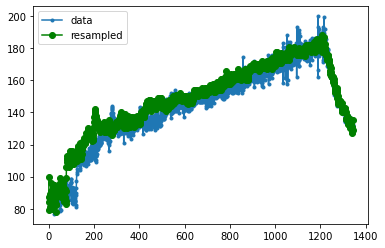

In [24]:
# not necessary
# plot to compare original signal to resampled signal
plt.plot(df['time'], df['hr'], '.-', df_resampled['time'], df_resampled['hr'], 'go-')
plt.legend(['data', 'resampled'], loc='best')
plt.show()

In [11]:
# filter down df to only last 120s
# recovery is always 120s
n_rows = 120
df_resampled = df_resampled.tail(n_rows)

In [12]:
# get max value during recovery
df_resampled['hr'].max()

176.0

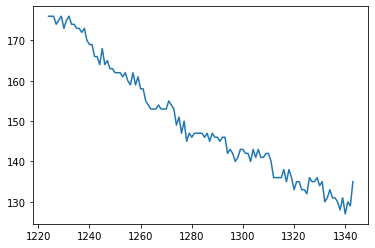

In [13]:
# plot recovery data
plt.plot(df_resampled['time'], df_resampled['hr'])
plt.show()

## Curve Fitting

In [40]:
def monoexponential_decay_fcn(t, hr_max, tau):
    """
    monoexponential decay

    :param hr_max: original amount/value. Constant.
    :param t: time variable
    :param tau: time constant
    :return:
    """

    return hr_max * (1 - np.exp(-t/tau))

In [ ]:
# fit monoexponential decay function
# todo: fix as it currently does not fit the data
popt, pcov = curve_fit(monoexponential_decay_fcn, df_resampled['time'], df_resampled['hr'])

In [14]:
# perform linear regression
result = linregress(df_resampled['time'], df_resampled['hr'])

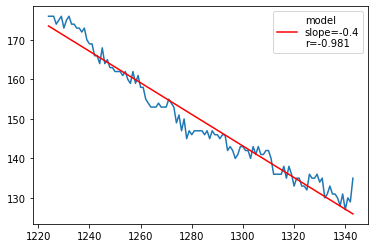

In [15]:
# plot linear regression for full data set
x = df_resampled['time']
plt.plot(x, df_resampled['hr'])
plt.plot(x, result.intercept + result.slope * x, 'r', label=f'model\nslope={round(result.slope, 3)}\nr={round(result.rvalue, 3)}')
plt.legend()
plt.show()

In [22]:
# perform linear regression for 1s:60s, and 61s:120s

lm_first_60 = linregress(df_resampled['time'].head(60), df_resampled['hr'].head(60))
lm_second_60 = linregress(df_resampled['time'].tail(60), df_resampled['hr'].tail(60))

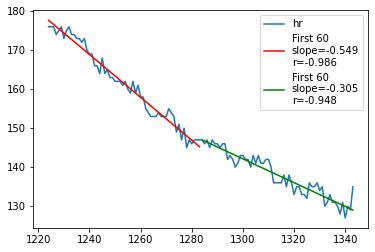

In [27]:
# plot new regressions
x_first_60 = df_resampled['time'].head(60)
y_first_60 = df_resampled['hr'].head(60)
x_second_60 = df_resampled['time'].tail(60)
y_second_60 = df_resampled['hr'].tail(60)

plt.plot(df_resampled['time'], df_resampled['hr'], label="hr")
plt.plot(
    x_first_60,
    lm_first_60.intercept + lm_first_60.slope * x_first_60,
    'r',
    label=f'First 60\nslope={round(lm_first_60.slope, 3)}\nr={round(lm_first_60.rvalue, 3)}',
)
plt.plot(
    x_second_60,
    lm_second_60.intercept + lm_second_60.slope * x_second_60,
    'g',
    label=f'First 60\nslope={round(lm_second_60.slope, 3)}\nr={round(lm_second_60.rvalue, 3)}'
)
plt.legend()
plt.show()